In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data = pd.DataFrame(web.DataReader("UVXY", data_source="yahoo", start= "2014-10-04")["Adj Close"])

In [22]:
data.head()

,Adj Close
Date,
2014-10-06,68700.0
2014-10-07,78225.0
2014-10-08,65150.0
2014-10-09,76525.0
2014-10-10,93975.0


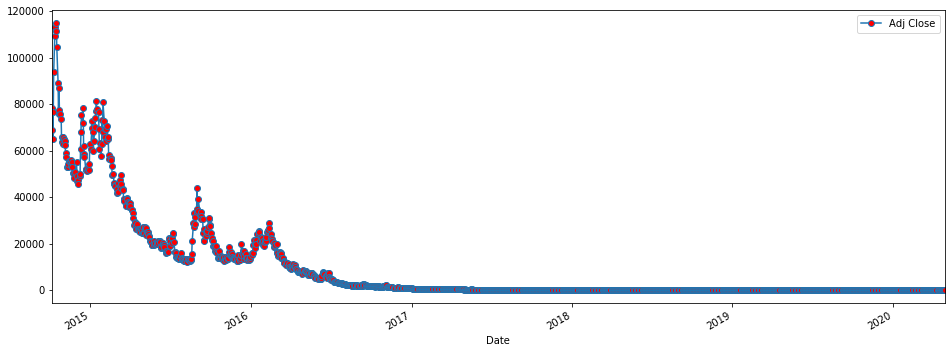

In [23]:
data.plot(figsize = (16,6), marker = "o", mfc = "r");

### Daily Data 
- Modeling data on based on 261 working days, 3 years (783)

## Spliting
- we will take 30days of the data as our training set..

In [24]:
test_size = 261

In [25]:
test_index = int(len(data) - test_size)

In [26]:
test_index

1139

In [27]:
len(data)

1400

## Training

In [28]:
train = data.iloc[:test_index]

In [29]:
test = data.iloc[test_index:]

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1139 entries, 2014-10-06 to 2019-04-15
Data columns (total 1 columns):
Adj Close    1139 non-null float64
dtypes: float64(1)
memory usage: 17.8 KB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2019-04-16 to 2020-04-28
Data columns (total 1 columns):
Adj Close    261 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


### Scaling the data

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scalar = MinMaxScaler()

In [34]:
train_scaled = scalar.fit_transform(train)

In [35]:
train_scaled.shape

(1139, 1)

In [36]:
test_scaled = scalar.transform(test)

In [37]:
test_scaled.shape

(261, 1)

## Plots

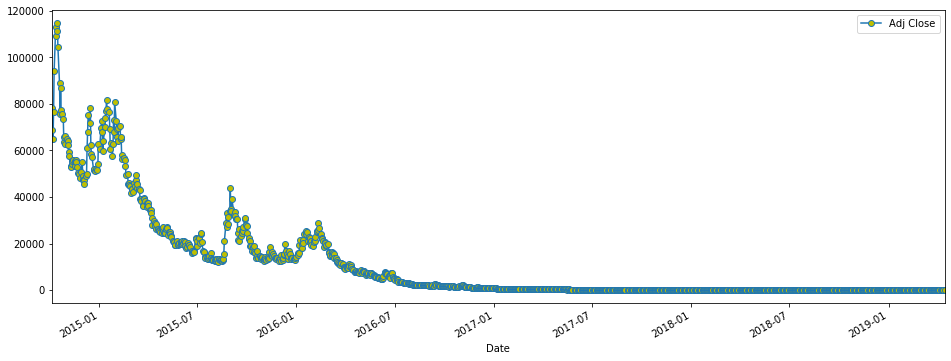

In [38]:
train.plot(figsize = (16,6), marker = "o", mfc = "y")

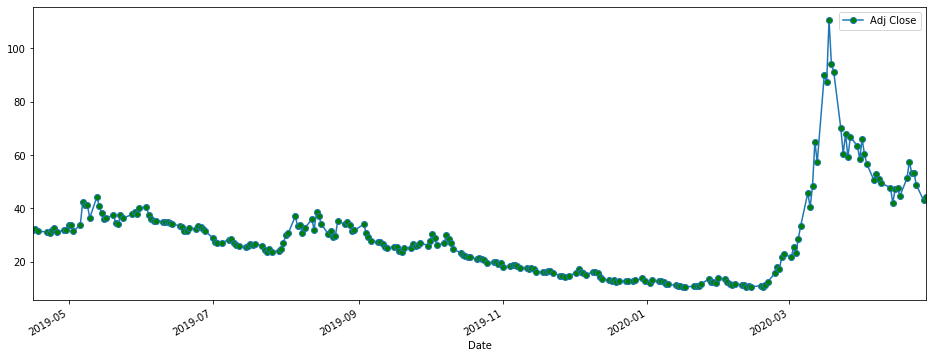

In [39]:
test.plot(figsize = (16,6), marker = "o", mfc = "g")

### Batches with time series Generator

In [40]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
length = 260
generator = TimeseriesGenerator(train_scaled,train_scaled, batch_size=1,length= length)

## Reviewing Generator
- Generator is proving to be structured correctly for the y value at position 30 is accurate

In [54]:
X,y = generator[0]

In [55]:
X

array([[[0.59805838],
        [0.681016  ],
        [0.5671398 ],
        [0.66620991],
        [0.81819001],
        [0.98541165],
        [0.94970286],
        [0.96995236],
        [1.        ],
        [0.91138124],
        [0.77420723],
        [0.65750045],
        [0.75744152],
        [0.67361296],
        [0.65771819],
        [0.63964606],
        [0.5558175 ],
        [0.57149453],
        [0.57476057],
        [0.54623709],
        [0.56387375],
        [0.55712392],
        [0.5421001 ],
        [0.51488303],
        [0.50007695],
        [0.46262627],
        [0.46110211],
        [0.47133573],
        [0.48265803],
        [0.48505313],
        [0.48374671],
        [0.4652391 ],
        [0.48853691],
        [0.48048066],
        [0.46001343],
        [0.43889299],
        [0.43562694],
        [0.41886123],
        [0.44150582],
        [0.47917424],
        [0.42561106],
        [0.40993403],
        [0.41145818],
        [0.39752305],
        [0.42626427],
        [0

In [56]:
y

array([[0.13872142]])

In [58]:
train_scaled[260]

array([0.13872142])

### Model Creation

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, LSTM

In [60]:
n_features = 1

In [61]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(optimization = "adam", loss = "mse")

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Earlly Stopping:
- Since RNN takes time to train we can set our Epoch value and let tensorFLow deside to stop training when the loss value is low enough and break when the model begins to overtrain

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
early = EarlyStopping(monitor= "val_loss", patience=2)

### Vaidation generator
-- Since we are fitting to a generator our validation data must come from a generator and out validation data will come from our scaled test set

In [65]:
validation_g = TimeseriesGenerator(test_scaled,test_scaled,length= length,batch_size=1)

## fitting model

In [66]:
model.fit_generator(generator, validation_data=validation_g, epochs=20, callbacks=[early])

Epoch 1/20
879/879 [==============================] - 4985s 6s/step - loss: nan - val_loss: nan
Epoch 2/20
193/879 [=====>........................] - ETA: 1:09:58 - loss: nan

KeyboardInterrupt: 

## model performance 

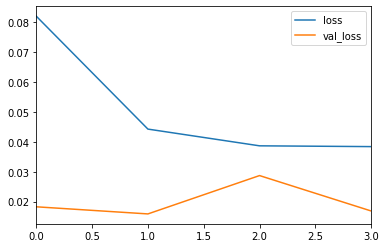

In [221]:
pd.DataFrame(model.history.history).plot()

## Test predictions
- Using our model to make predictions on the Testing data

In [222]:
test_predictions = []
first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predictions.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediciton]], axis = 1)
    

### inverse Scaling
- WE have to remember out model was trained on scaled data so we need to inverse this process for the true value
- we will then need to match these predicitons up with our original test data

In [178]:
true_predictions = scalar.inverse_transform(test_predictions)

In [179]:
test["predicitons"] = true_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
test

,Adj Close,predicitons
Date,,
2020-03-10,40.450001,26.345742
2020-03-11,48.220001,26.291161
2020-03-12,65.019997,26.221076
2020-03-13,57.240002,26.063062
2020-03-16,90.139999,25.820681
2020-03-17,87.230003,25.510536
2020-03-18,110.629997,25.145854
2020-03-19,94.089996,24.738097
2020-03-20,91.110001,24.297278


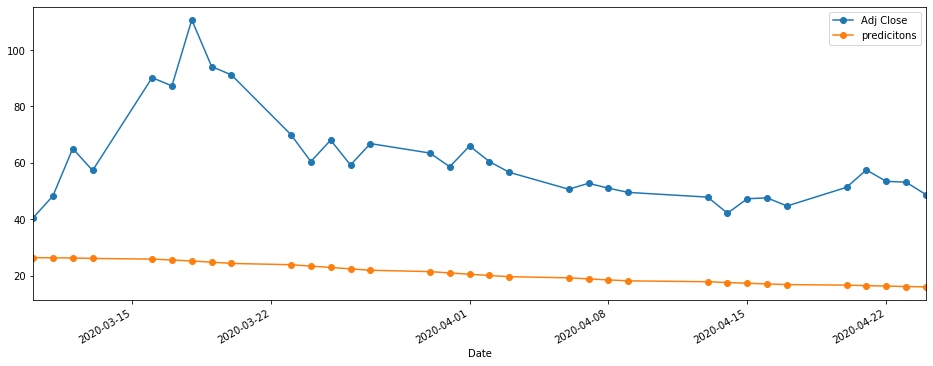

In [181]:
test.plot(figsize = (16,6), marker = "o")